In [1]:
import pandas as pd
import numpy as np
import json
import os
import requests
from config import api_key, postgres_pass#, heroku_pass, heroku_URI
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import joblib
import tensorflow as tf
import keras
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
#Select Ticker
ticker = 'amzn'
tick = yf.Ticker(ticker)
# pull Ticker details from Yahoo Finance
history = tick.history(period="max")

In [3]:
# Yahoo API

#ticvker = 'kim'
#endpoint = "/v11/finance/quoteSummary/"
#url = "https://yfapi.net" + endpoint + ticker
#querystring = {"modules":"defaultKeyStatistics"}

#headers = {
#    'x-api-key': api_key
#    }

#response = requests.request("GET", url, headers=headers, params=querystring)

#tick_resp = response
#tick_resp.json()['quoteSummary']['result'][0]['defaultKeyStatistics']

In [4]:
history.isnull().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [5]:
len(history)

6258

In [6]:
history.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [7]:
history.dtypes

Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends         int64
Stock Splits    float64
dtype: object

In [8]:
history.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,6258.000000,6258.000000,6258.000000,6258.000000,6.258000e+03,6258.0,6258.000000
mean,565.439495,571.782875,558.434027,565.253680,7.269756e+06,0.0,0.001119
std,918.680161,928.605829,907.524685,918.064056,7.108241e+06,0.0,0.052112
min,1.406250,1.447917,1.312500,1.395833,4.872000e+05,0.0,0.000000
25%,39.009998,39.799999,38.365001,39.067501,3.536350e+06,0.0,0.000000
50%,106.277500,110.957500,101.750000,104.343750,5.424150e+06,0.0,0.000000
75%,596.567520,601.875000,588.824997,594.414978,8.240300e+06,0.0,0.000000
max,3744.000000,3773.080078,3696.790039,3731.409912,1.043292e+08,0.0,3.000000


In [9]:
history.to_csv('history_data.csv', index=False)

In [10]:
df_hist = pd.read_csv('history_data.csv')
df_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2.437500,2.500000,1.927083,1.958333,72156000,0,0.0
1,1.968750,1.979167,1.708333,1.729167,14700000,0,0.0
2,1.760417,1.770833,1.625000,1.708333,6106800,0,0.0
3,1.729167,1.750000,1.635417,1.635417,5467200,0,0.0
4,1.635417,1.645833,1.375000,1.427083,18853200,0,0.0
...,...,...,...,...,...,...,...
6253,3222.419922,3261.679932,3191.060059,3229.830078,3326900,0,0.0
6254,3236.110107,3323.340088,3233.979980,3297.780029,3204300,0,0.0
6255,3274.100098,3327.399902,3253.739990,3268.159912,2790600,0,0.0
6256,3274.989990,3282.370117,3201.000000,3272.989990,2839900,0,0.0


In [11]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

In [12]:
# looking at a stock history (features)
lags = 500

# looking at a 2-day stock forecast (targets)
steps = 2

# define lead time
lead_time=1

In [26]:
# Number of weeks of lag features
y = history.drop(columns=['Dividends', 'Stock Splits'])
X = make_lags(y, lags=lags).fillna(0.0)
X

y_lag_1                                                     \
                   Open         High          Low        Close      Volume   
Date                                                                         
1997-05-15     0.000000     0.000000     0.000000     0.000000         0.0   
1997-05-16     2.437500     2.500000     1.927083     1.958333  72156000.0   
1997-05-19     1.968750     1.979167     1.708333     1.729167  14700000.0   
1997-05-20     1.760417     1.770833     1.625000     1.708333   6106800.0   
1997-05-21     1.729167     1.750000     1.635417     1.635417   5467200.0   
...                 ...          ...          ...          ...         ...   
2022-03-21  3136.260010  3231.879883  3120.219971  3225.010010   5141300.0   
2022-03-22  3222.419922  3261.679932  3191.060059  3229.830078   3326900.0   
2022-03-23  3236.110107  3323.340088  3233.979980  3297.780029   3204300.0   
2022-03-24  3274.100098  3327.399902  3253.739990  3268.159912   2790600.0   
2022-03-25  3274.989990  3282.370117  3201.000000  3272.989990   2839900.0   

                y_lag_2                                                     \
                   Open         High          Low        Close      Volume   
Date                                                                         
1997-05-15     0.000000     0.000000     0.000000     0.000000         0.0   
1997-05-16     0.000000     0.000000     0.000000     0.000000         0.0   
1997-05-19     2.437500     2.500000     1.927083     1.958333  72156000.0   
1997-05-20     1.968750     1.979167     1.708333     1.729167  14700000.0   
1997-05-21     1.760417     1.770833     1.625000     1.708333   6106800.0   
...                 ...          ...          ...          ...         ...   
2022-03-21  3052.810059  3149.969971  3042.800049  3144.780029   3646700.0   
2022-03-22  3136.260010  3231.879883  3120.219971  3225.010010   5141300.0   
2022-03-23  3222.419922  3261.679932  3191.060059  3229.830078   3326900.0   
2022-03-24  3236.110107  3323.340088  3233.979980  3297.780029   3204300.0   
2022-03-25  3274.100098  3327.399902  3253.739990  3268.159912   2790600.0   

            ...    y_lag_499                                         \
            ...         Open         High          Low        Close   
Date        ...                                                       
1997-05-15  ...     0.000000     0.000000     0.000000     0.000000   
1997-05-16  ...     0.000000     0.000000     0.000000     0.000000   
1997-05-19  ...     0.000000     0.000000     0.000000     0.000000   
1997-05-20  ...     0.000000     0.000000     0.000000     0.000000   
1997-05-21  ...     0.000000     0.000000     0.000000     0.000000   
...         ...          ...          ...          ...          ...   
2022-03-21  ...  1930.859985  1939.790039  1899.920044  1900.099976   
2022-03-22  ...  1922.829956  1973.630005  1912.339966  1963.949951   
2022-03-23  ...  1964.349976  1993.020020  1944.010010  1949.719971   
2022-03-24  ...  1932.969971  1944.959961  1893.000000  1907.699951   
2022-03-25  ...  1901.640015  1927.530029  1890.000000  1918.829956   

                         y_lag_500                                         \
               Volume         Open         High          Low        Close   
Date                                                                        
1997-05-15        0.0     0.000000     0.000000     0.000000     0.000000   
1997-05-16        0.0     0.000000     0.000000     0.000000     0.000000   
1997-05-19        0.0     0.000000     0.000000     0.000000     0.000000   
1997-05-20        0.0     0.000000     0.000000     0.000000     0.000000   
1997-05-21        0.0     0.000000     0.000000     0.000000     0.000000   
...               ...          ...          ...          ...          ...   
2022-03-21  5387900.0  1902.000000  1956.489990  1889.290039  1955.489990   
2022-03-22  6126100.0  1930.859985  1939.790039  1899.920044  190

In [27]:
# Number of days forecast
y = y.loc[:, 'Close'] # Targer Variable is Close
y = make_multistep_target(y, steps=steps).dropna()
y

,y_step_1,y_step_2
Date,,
1997-05-15,1.958333,1.729167
1997-05-16,1.729167,1.708333
1997-05-19,1.708333,1.635417
1997-05-20,1.635417,1.427083
1997-05-21,1.427083,1.395833
...,...,...
2022-03-18,3225.010010,3229.830078
2022-03-21,3229.830078,3297.780029
2022-03-22,3297.780029,3268.159912


In [28]:
# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

In [29]:
model = LinearRegression()
model.fit(X,y)

y_pred = pd.DataFrame(model.predict(X), index=X.index)

C:\Users\levfl\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\levfl\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [34]:
ax = y_pred[0].tail(40).plot(figsize=(11, 8), color='red')
ax = y['y_step_1'].tail(40.plot(figsize=(11, 8), color = 'green')

SyntaxError: invalid syntax (Temp/ipykernel_17780/3192531104.py, line 2)

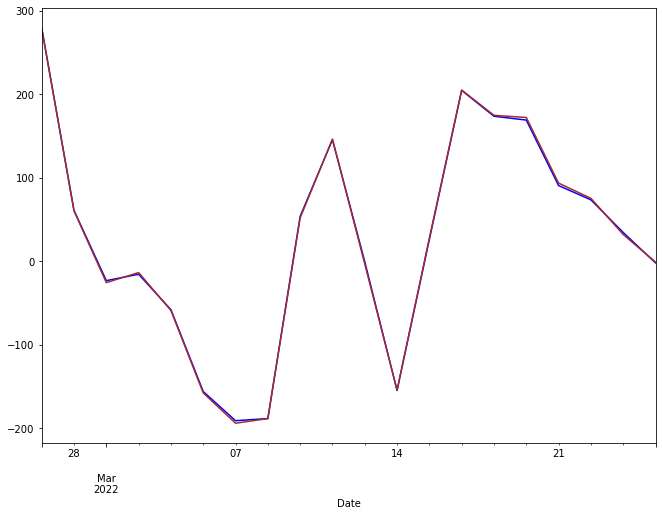

In [18]:
# Delta between Open and Closing Price
profit_pred = - X.y_lag_1['Open'] + y_pred[0]
for i,d in enumerate(profit_pred):
    if i>5:
        act = 'buy'
    else:
        act ='stay'
#    profit_pred.loc[i,0]
        
profit_act = - X.y_lag_1['Open'] + y.y_step_1
ax = profit_pred.tail(20).plot(figsize=(11, 8), color='blue')
ax = profit_act.tail(20).plot(figsize=(11, 8), color='brown')

In [19]:
# Split the preprocessed data into a training and testing dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X)
    
# Scale the data
X_scaled = X_scaler.transform(X)
    
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_scaled[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 30

#nn = tf.keras.models.Sequential()
nn = keras.models.Sequential()

# First hidden layer
nn.add(keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(keras.layers.Dense(units=1, activation="linear"))

# Check the structure of the model
nn.summary()
    
train_size = len(X_scaled)
#train_size
    
batch_size = 32
steps_per_epoch = train_size / batch_size
save_period = 5
save_freq = int(save_period * steps_per_epoch)
    
# Compile the model
nn.compile(loss="mean_absolute_error", optimizer="adam")
    
 # Train the model
fit_model = nn.fit(X_scaled, y, epochs=50, batch_size = batch_size)
    
# Evaluate the model using the test data
model_loss = nn.evaluate(X_scaled, y, verbose=2)
print(f"Loss: {model_loss}")
    
# Calculate Adjusted r-square
#import statsmodels.api as sm
#XaddC = sm.add_constant(X_scaled)
#result = sm.OLS(y, XaddC).fit()
#print(f"R-Squared: {result.rsquared}, R-Squared Adjusted: {result.rsquared_adj}")

C:\Users\levfl\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\levfl\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                200080    
                                                                 
 dense_1 (Dense)             (None, 30)                2430      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 202,541
Trainable params: 202,541
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
196/196 [==============================] - 1s 6ms/step - loss: 254.3281
Epoch 2/50
196/196 [==============================] - 1s 3ms/step - loss: 87.7455
Epoch 3/50
196/196 [==============================] - 1s 4ms/step - loss: 61.5534
Epoch 4/50
196/196 [==============================] - 0s 2ms/step -

In [20]:
y_pred = pd.DataFrame(nn.predict(X_scaled), index = X.index)

196/196 [==============================] - 0s 2ms/step


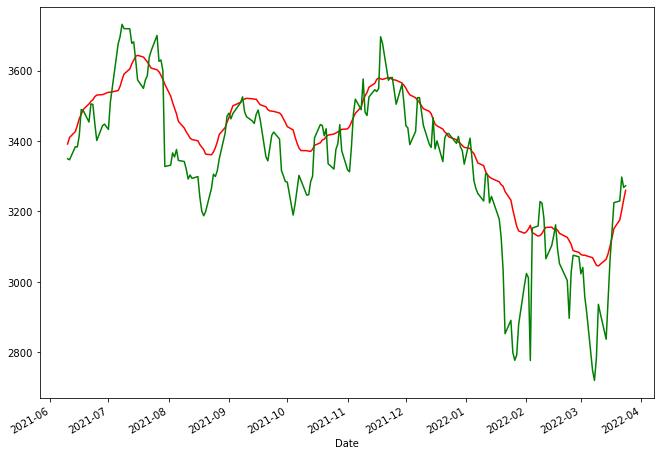

In [21]:
ax = y_pred[0].tail(200).plot(figsize=(11, 8), color='red')
ax = y['y_step_1'].tail(200).plot(figsize=(11, 8), color = 'green')

In [22]:
#len(X[0])

In [23]:
# Split the preprocessed data into a training and testing dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X)
    
# Scale the data
X_scaled = X_scaler.transform(X)
    
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_scaled[0])
hidden_nodes_layer1 = 40
hidden_nodes_layer2 = 20

#nn = tf.keras.models.Sequential()
nn = keras.models.Sequential()

# First hidden layer
nn.add(keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(keras.layers.Dense(units=1, activation="linear"))

# Check the structure of the model
nn.summary()
    
#train_size = len(X)
#train_size
    
#batch_size = 32
#steps_per_epoch = train_size / batch_size
#save_period = 5
#save_freq = int(save_period * steps_per_epoch)
    
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam")
    
 # Train the model
fit_model = nn.fit(X_scaled, y, epochs=50) #, batch_size = batch_size)
    
# Evaluate the model using the test data
model_loss = nn.evaluate(X_scaled, y, verbose=2)
print(f"Loss: {model_loss}")

C:\Users\levfl\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 40)                100040    
                                                                 
 dense_4 (Dense)             (None, 20)                820       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 100,881
Trainable params: 100,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
196/196 [==============================] - 1s 2ms/step - loss: 344519.0625
Epoch 2/50
196/196 [==============================] - 0s 2ms/step - loss: 22168.3438
Epoch 3/50
196/196 [==============================] - 1s 3ms/step - loss: 10501.3330
Epoch 4/50
196/196 [==============================] - 0s

C:\Users\levfl\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


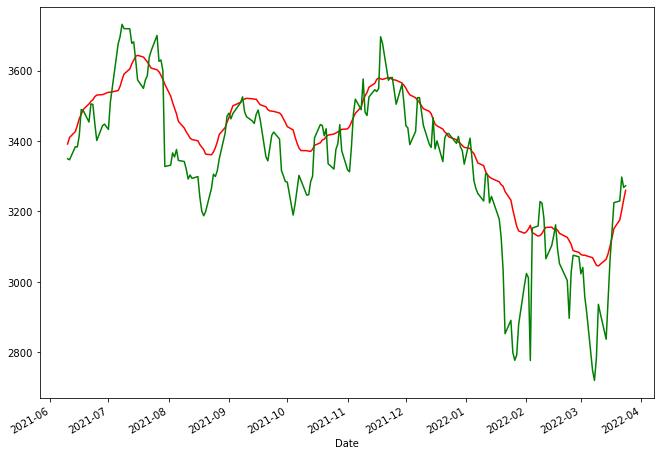

In [24]:
ax = y_pred[0].tail(200).plot(figsize=(11, 8), color='red')
ax = y['y_step_1'].tail(200).plot(figsize=(11, 8), color = 'green')